![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Certification_Trainings/Medical_Language_Models/April_2025/Notebooks/Dicom_Deidentification_Using_Metadata.ipynb)

<!DOCTYPE html>
<html>
<body>

<h1>DICOM-Metadata Pixel Deidentification:</h1>

<p>This notebook provides a hands-on demonstration of deidentifying Protected Health Information (PHI) from DICOM pixel data with the help of metadata tags. We’ll walk through the key steps and include code examples to guide you through the process.</p>

<h2>Environment Setup:</h2>

<ul>
    <li><strong>Google Colab (Recommended):</strong> If you are using Google Colab, the environment is generally pre-configured for many dependencies.</li>
    <li><strong>Local Setup (If not using Colab):</strong>
        <ul>
            <li><strong>Homebrew:</strong> Ensure you have Homebrew installed. (e.g., <code>/bin/bash -c "$(curl -fsSL https://raw.githubusercontent.com/Homebrew/install/HEAD/install.sh)"</code></li>
            <li><strong>Apache Spark:</strong> Install Apache Spark (e.g., <code>brew install apache-spark</code> By default OpenJDK 17 will be installed.</li>
            <li><strong>OpenJDK 17:</strong> Ensure you have Java Path configured before starting <code>spark-ocr</code> session <code>os.environ['JAVA_HOME'] = '/home/linuxbrew/.linuxbrew/Cellar/openjdk@17/17.0.14'</code></li>
        </ul>
    </li>
</ul>

<h2>Required Libraries:</h2>

<ul>
    <li><strong>Spark-OCR:</strong> This library is crucial for text detection and Optical Character Recognition (OCR) and IO operations related to DICOM images.</li>
    <li><strong>Spark-NLP-Healthcare:</strong> This library provides advanced Named Entity Recognition (NER) models specifically designed for medical text, enabling accurate PHI identification.</li>
    <li><strong>Spark-NLP: </strong>Open Source Library installed automatically with Visual NLP.</li>
</ul>

<img
  src="https://www.johnsnowlabs.com/wp-content/uploads/2023/03/visual_nlp.png"
  alt="Visual NLP Diagram from John Snow Labs"
  style="max-width: 100%; height: auto;" >
</body>
</html>

<h2>Installation Steps</h2>
<ul>
    <li>Make sure license file is present in the same directory, and <strong>license</strong> variable is populated.</li>
    <li>Set Environment Variables.</li>
    <li>Install Visual-NLP, Healthcare-NLP, Pandas and Matplotlib.</li>
    <li><strong>Restart Session!!!!<strong></li>
</ul>

In [ ]:
import json
import os

license = ""

if license and "json" in license:

    with open(license, "r") as creds_in:
        creds = json.loads(creds_in.read())

        for key in creds.keys():
            os.environ[key] = creds[key]
else:
    raise Exception("License JSON File is not specified")

In [ ]:
# Install Visual-NLP
!python3 -m pip install -q --upgrade spark-ocr==$OCR_VERSION --user --extra-index-url https://pypi.johnsnowlabs.com/$SPARK_OCR_SECRET

In [ ]:
# Install Healthcare-NLP
!python3 -m pip install -q --upgrade spark-nlp-jsl==$JSL_VERSION --extra-index-url https://pypi.johnsnowlabs.com/$SECRET

In [ ]:
!pip install -q pandas matplotlib

In [ ]:
# RESTART SESSION!!!

<h2>Notebook Objectives:</h2>

<p>This notebook will illustrate the following key stages of DICOM pixel deidentification:</p>

<ul>
    <li>Loading and processing DICOM images and metadata.</li>
    <li>Detecting text within the image pixels using Spark-OCR.</li>
    <li>Performing Optical Character Recognition (OCR) to extract the detected text.</li>
    <li>Extract NER using metadata and positions.</li>
    <li>Identifying PHI entities within the extracted text using Spark-NLP-Healthcare's NER models.</li>
    <li>De-Identifying the sensitive PHI regions within the pixel data.</li>
</ul>

<p>By following this notebook, you will gain practical experience in building a DICOM pixel deidentification pipeline using Visual-NLP and Healthcare-NLP.</p>

<h2>Start Visual-NLP Session with Healthcare-NLP</h2>

<h2>Configuration:</h2>

<p>To execute the code, you'll need to provide the following configuration details:</p>

<ol>
    <li><strong>License Information:</strong>
        <ul>
            <li>Specify the license for <code>Spark-OCR</code> OR <code>Spark-NLP-Healthcare</code> license from your license file.</li>
        </ul>
    </li>
    <li><strong>Library Paths:</strong>
        <ul>
            <li>Provide the folder path to the <code>spark-ocr-assembly-[version].jar</code>file or <code>spark_ocr_secret</code> from your license file.</li>
            <li>Provide the folder path to the <code>spark-nlp-jsl-[version].jar</code>file or <code>nlp_secret</code> from your license file.</li>
        </ul>
    </li>
    <li><strong>AWS Credentials (for Model Downloads):</strong>
        <ul>
            <li>Supply your AWS access key (<code>aws_access_key</code>).</li>
            <li>Supply your AWS secret key (<code>aws_secret_key</code>).</li>
            <li>Supply your AWS session token (<code>aws_session_token</code>).</li>
        </ul>
    </li>
</ol>

In [ ]:
from sparkocr import start
import os
import json
import time
import shutil

license = ""

if license and "json" in license:

    with open(license, "r") as creds_in:
        creds = json.loads(creds_in.read())

        for key in creds.keys():
            os.environ[key] = creds[key]
else:
    raise Exception("License JSON File is not specified")

In [ ]:
extra_configurations = {
    "spark.extraListeners": "com.johnsnowlabs.license.LicenseLifeCycleManager",
}

# Set Java Path
# Not Required on Google Collab
os.environ['JAVA_HOME'] = '/home/linuxbrew/.linuxbrew/Cellar/openjdk@17/17.0.14'

spark = start(secret=os.environ["SPARK_OCR_SECRET"],
              nlp_secret=os.environ["SECRET"],
              nlp_internal=True,
              nlp_jsl=True,
              nlp_version=os.environ["PUBLIC_VERSION"],
              extra_conf=extra_configurations,
              use_gpu=False)

spark

<h2>Import Transformers and Annotators</h2>

In [ ]:
import os
import sys
import time
from PIL import Image
import io

from sparknlp.annotator import *
from sparknlp.base import *
import sparknlp_jsl
from sparknlp_jsl.annotator import *

import sparkocr
from sparkocr.transformers import *
from sparkocr.utils import *
from sparkocr.enums import *

from pyspark.ml import PipelineModel, Pipeline
from sparknlp.pretrained import PretrainedPipeline
from pyspark.ml import PipelineModel, Pipeline

import pyspark.sql.functions as F

print(f"Spark NLP version: {sparknlp.version()}")
print(f"Spark NLP internal version: {sparknlp_jsl.version()}")
print(f"Spark OCR version: {sparkocr.version()}")

Spark NLP version: 5.5.2
Spark NLP internal version: 5.5.2
Spark OCR version: 5.5.1rc4


<h2>Building the DICOM Deidentification Pipeline</h2>

<p>We'll construct a pipeline designed to extract and deidentify Protected Health Information (PHI) from DICOM images with the help of metadata. This process involves several key stages:</p>

<ol>
    <li>
        <strong>DICOM Image & Metadata Processing</strong>
        <ul>
            <li>Integrate DICOM image & metadata handling, text detection, and Optical Character Recognition (OCR) stages from the Visual NLP library. This allows the pipeline to process DICOM images and extract text from pixels and metadata.</li>
        </ul>
    </li>
    <li>
        <strong>DicomDeidentification Stage</strong>
        <ul>
            <li>Generate NER using positions and metadata.</li>
        </ul>
    </li>
    <li>
        <strong>Generate Coordinates</strong>
        <ul>
            <li>With ner_chunks and positions, coordinates can be generated for Sensitive PHI, which is then fed into the final Dicom Stages.      </li>
        </ul>
    </li>
</ol>

In [ ]:
dicom_to_metadata = DicomToMetadata() \
    .setInputCol("content") \
    .setOutputCol("metadata") \
    .setKeepInput(True)

dicom_to_image = DicomToImageV3() \
    .setInputCols(["content"]) \
    .setOutputCol("image_raw") \
    .setKeepInput(True)

text_detector = ImageTextDetector.pretrained("image_text_detector_mem_opt", "en", "clinical/ocr") \
    .setInputCol("image_raw") \
    .setOutputCol("text_regions") \
    .setScoreThreshold(0.7) \
    .setWithRefiner(True) \
    .setTextThreshold(0.4) \
    .setLinkThreshold(0.5) \
    .setSizeThreshold(1) \
    .setUseGPU(False) \
    .setWidth(0) \
    .setHeight(0)

ocr = ImageToTextV3() \
    .setInputCols(["image_raw", "text_regions"]) \
    .setOutputCol("text")

deidentifier = DicomDeidentifier() \
    .setInputCols(["positions", "metadata"]) \
    .setOutputCol("entity") \
    .setKeepInput(True) \
    .setBlackList(["acc"])

position_finder = PositionFinder() \
    .setInputCols("entity") \
    .setOutputCol("coordinates") \
    .setPageMatrixCol("positions") \
    .setIgnoreSchema(True)

stages = [
    dicom_to_metadata,
    dicom_to_image,
    text_detector,
    ocr,
    deidentifier,
    position_finder,
]

dicom_pipe = Pipeline(stages=stages)

In [ ]:
stages

[DicomToMetadata_2ac2ddf217c5,
 DicomToImageV3_1816d66ea0a2,
 ImageTextDetectorCraft_ccda95600a38,
 ImageToTextV3_c9f47b3ffe3b,
 DicomDeidentifier_d1fce8132676,
 PositionFinder_d251125412f9]

<h3>Load a Single Dicom File and Extract Results</h3>

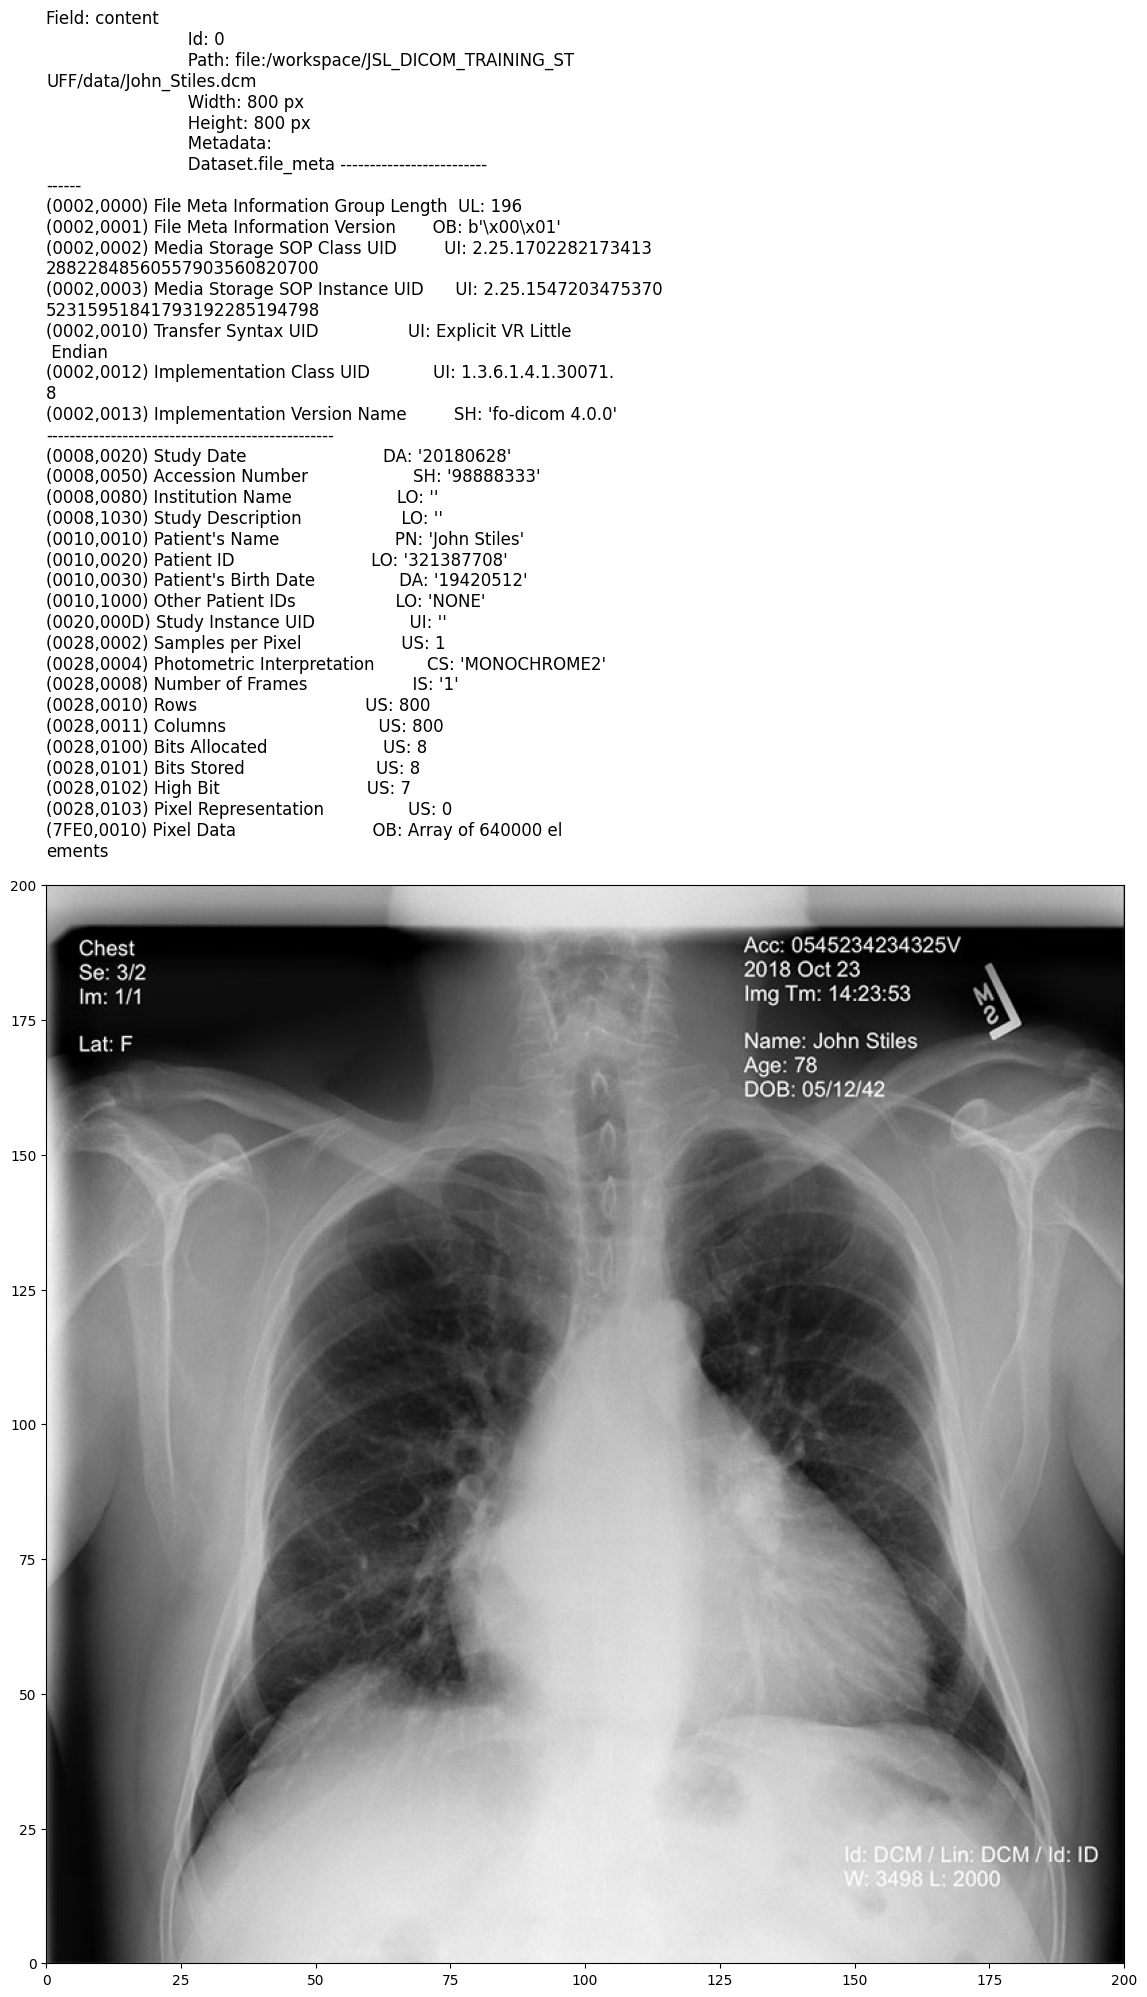

In [ ]:
df = spark.read.format("binaryFile").load("./data/John_Stiles.dcm")

display_dicom(df, "content")

In [ ]:
result = dicom_pipe.fit(df).transform(df).cache()

result.columns

/root/.local/lib/python3.11/site-packages/pyspark/sql/dataframe.py:168: UserWarning: DataFrame.sql_ctx is an internal property, and will be removed in future releases. Use DataFrame.sparkSession instead.
  warnings.warn(


['entity',
 'exception',
 'image_raw',
 'pagenum',
 'path',
 'modificationTime',
 'length',
 'content',
 'text_regions',
 'text',
 'positions',
 'coordinates']

<h3>Visualization of Detected Text Regions</h3>

In [ ]:
result.select(F.explode("text_regions").alias("detected_regions")).show(50, False)

13:37:37, INFO Run DicomToImageV3                                   (0 + 1) / 1]
13:37:37, INFO DicomToImageV3: Number of frames: 1
13:37:49, INFO Run DicomDeidentifier
/root/.local/lib/python3.11/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


+----------------------------------------------------------------------------+
|detected_regions                                                            |
+----------------------------------------------------------------------------+
|{0, 0, 597.0, 44.0, 16.0, 166.0, 0.99607843, 0, 90.0, true}                 |
|{0, 0, 46.0, 47.0, 14.0, 44.0, 0.99215686, 0, 90.0, true}                   |
|{0, 0, 561.0, 63.0, 14.0, 90.0, 0.99607843, 0, 90.0, true}                  |
|{0, 0, 48.0, 65.0, 18.0, 56.0, 0.9019608, 0, 90.0, true}                    |
|{0, 0, 579.0, 81.0, 18.0, 130.0, 0.9529412, 0, 90.0, true}                  |
|{0, 0, 699.0, 89.0, 34.0, 22.0, 0.90588236, 0, 90.0, true}                  |
|{0, 0, 49.0, 83.0, 14.0, 50.0, 0.81960785, 0, 90.0, true}                   |
|{0, 0, 582.0, 115.0, 18.0, 136.0, 0.99215686, 0, 90.0, true}                |
|{0, 0, 43.0, 118.0, 16.0, 46.0, 0.89411765, 0, 90.0, true}                  |
|{0, 0, 546.0, 137.0, 18.0, 60.0, 0.91764706, 0, 90.


    Image #0:
    Origin: file:/workspace/JSL_DICOM_TRAINING_STUFF/data/John_Stiles.dcm
    Resolution: 0 dpi
    Width: 800 px
    Height: 800 px
    Mode: 10
    Number of channels: 1


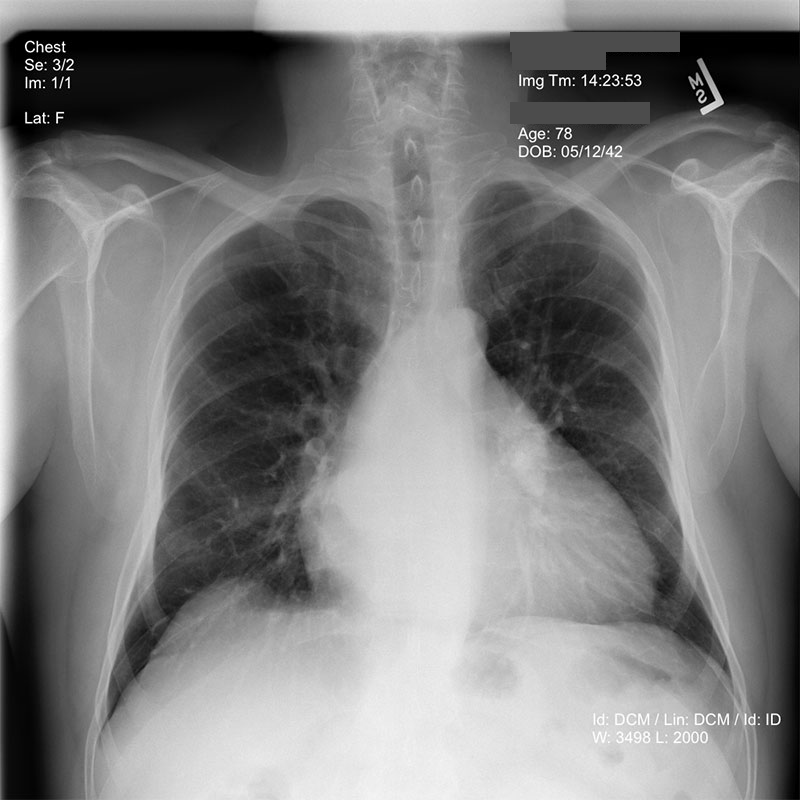

In [ ]:
draw = ImageDrawRegions() \
  .setInputCol("image_raw") \
  .setInputRegionsCol("coordinates") \
  .setRectColor(Color.red) \
  .setOutputCol("image_with_regions") \
  .setFilledRect(True)

display_images(draw.transform(result), "image_with_regions")

<h3>View the NER's detected Using Metadata</h3>

In [ ]:
# View the detected regions
result.select(F.explode("entity").alias("Metadata NER")).show(50, False)

+---------------------------------------------------+
|Metadata NER                                       |
+---------------------------------------------------+
|{named_entity, 0, 20, “Acc: 0545234234325V, {}, []}|
|{named_entity, 27, 38, 2018 Oct 23, {}, []}        |
|{named_entity, 75, 92, Name: John Stiles, {}, []}  |
+---------------------------------------------------+



<h3>Combining <strong>DicomDeidentifier</strong> with other NER Stages from Healthcare-NLP</h3>

In [ ]:
dicom_to_metadata = DicomToMetadata() \
    .setInputCol("content") \
    .setOutputCol("metadata") \
    .setKeepInput(True)

dicom_to_image = DicomToImageV3() \
    .setInputCols(["content"]) \
    .setOutputCol("image_raw") \
    .setKeepInput(True)

text_detector = ImageTextDetector.pretrained("image_text_detector_mem_opt", "en", "clinical/ocr") \
    .setInputCol("image_raw") \
    .setOutputCol("text_regions") \
    .setScoreThreshold(0.7) \
    .setWithRefiner(True) \
    .setTextThreshold(0.4) \
    .setLinkThreshold(0.5) \
    .setSizeThreshold(1) \
    .setUseGPU(False) \
    .setWidth(0) \
    .setHeight(0)

ocr = ImageToTextV3() \
    .setInputCols(["image_raw", "text_regions"]) \
    .setOutputCol("text")

deidentifier = DicomDeidentifier() \
    .setInputCols(["positions", "metadata"]) \
    .setOutputCol("entity") \
    .setKeepInput(True) \
    .setBlackList(["acc"])

document_assembler = DocumentAssembler() \
    .setInputCol("text") \
    .setOutputCol("document") \
    .setCleanupMode("disabled")

sentence_detector = SentenceDetectorDLModel.pretrained("sentence_detector_dl","xx")\
    .setInputCols(["document"])\
    .setOutputCol("sentence")

tokenizer = Tokenizer()\
    .setInputCols(["sentence"])\
    .setOutputCol("token")

glove_embeddings = WordEmbeddingsModel.pretrained('glove_100d') \
      .setInputCols(['sentence', 'token']) \
      .setOutputCol('embeddings_glove')

clinical_ner_glove = MedicalNerModel.pretrained("ner_deid_generic_glove", "en", "clinical/models") \
      .setInputCols(["sentence", "token", "embeddings_glove"]) \
      .setOutputCol("ner_glove")

ner_converter_glove = NerConverterInternalModel() \
        .setInputCols(["sentence", "token", "ner_glove"]) \
        .setOutputCol("ner_chunk_glove") \
        .setThreshold(0.7) \
        .setWhiteList(['AGE', 'DATE'])

chunk_merger = ChunkMergeApproach()\
    .setInputCols('ner_chunk_glove', "entity")\
    .setOutputCol('merged_ner_chunk') \
    .setMergeOverlapping(True)

position_finder = PositionFinder() \
    .setInputCols("merged_ner_chunk") \
    .setOutputCol("coordinates") \
    .setPageMatrixCol("positions")

stages = [
    dicom_to_metadata,
    dicom_to_image,
    text_detector,
    ocr,
    deidentifier,
    document_assembler,
    sentence_detector,
    tokenizer,
    glove_embeddings,
    clinical_ner_glove,
    ner_converter_glove,
    chunk_merger,
    position_finder,
]

dicom_pipe = Pipeline(stages=stages)

In [ ]:
stages

[DicomToMetadata_26e5e51d34a8,
 DicomToImageV3_3d83f05ef34e,
 ImageTextDetectorCraft_d3b7ad9b7d45,
 ImageToTextV3_134d535634db,
 DicomDeidentifier_976e6222e507,
 DocumentAssembler_8ce77e47bbb9,
 SentenceDetectorDLModel_8aaebf7e098e,
 Tokenizer_9bc6ed1bde5f,
 WORD_EMBEDDINGS_MODEL_48cffc8b9a76,
 MedicalNerModel_1c278433019e,
 NerConverterInternalModel_66b725ca4f42,
 ChunkMergeApproach_f007be959abb,
 PositionFinder_3d7b7b966111]

<h3>Load a Single Dicom File and Extract Results</h3>

In [ ]:
df = spark.read.format("binaryFile").load("./data/John_Stiles.dcm")

result = dicom_pipe.fit(df).transform(df).cache()

25/04/08 13:38:43 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [ ]:
#NER Output From Healthcare-NLP ner_deid_generic_glove

result.select(F.explode(F.arrays_zip(result.ner_chunk_glove.result, result.ner_chunk_glove.metadata)).alias("cols")) \
                      .select(F.expr("cols['0']").alias("ner_chunk"),
                              F.expr("cols['1']['confidence']").alias("confidence"),
                              F.expr("cols['1']['entity']").alias("chunk_class")).show(truncate=False)

13:39:01, INFO Run DicomToImageV3                                   (0 + 1) / 1]
13:39:01, INFO DicomToImageV3: Number of frames: 1
13:39:12, INFO Run DicomDeidentifier
/root/.local/lib/python3.11/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


+---------+----------+-----------+
|ner_chunk|confidence|chunk_class|
+---------+----------+-----------+
|2018     |0.9993    |DATE       |
|Oct 23   |0.92285   |DATE       |
|78       |0.9414    |AGE        |
|05/12/42 |1.0       |DATE       |
+---------+----------+-----------+



In [ ]:
#NER Output from Visual-NLP DicomDeidentifier Stage

result.select(F.explode(F.arrays_zip(result.entity.result, result.entity.metadata)).alias("cols")) \
                      .select(F.expr("cols['0']").alias("ner_chunk"),
                              F.expr("cols['1']['confidence']").alias("confidence"),
                              F.expr("cols['1']['entity']").alias("chunk_class")).show(truncate=False)

+--------------------+----------+-----------+
|ner_chunk           |confidence|chunk_class|
+--------------------+----------+-----------+
|“Acc: 0545234234325V|NULL      |NULL       |
|2018 Oct 23         |NULL      |NULL       |
|Name: John Stiles   |NULL      |NULL       |
+--------------------+----------+-----------+



In [ ]:
#Combined NER output

result.select(F.explode(F.arrays_zip(result.merged_ner_chunk.result, result.merged_ner_chunk.metadata)).alias("cols")) \
                      .select(F.expr("cols['0']").alias("ner_chunk"),
                              F.expr("cols['1']['confidence']").alias("confidence"),
                              F.expr("cols['1']['entity']").alias("chunk_class")).show(truncate=False)

+--------------------+----------+-----------+
|ner_chunk           |confidence|chunk_class|
+--------------------+----------+-----------+
|“Acc: 0545234234325V|NULL      |UNK        |
|2018 Oct 23         |NULL      |UNK        |
|Name: John Stiles   |NULL      |UNK        |
|78                  |0.9414    |AGE        |
|05/12/42            |1.0       |DATE       |
+--------------------+----------+-----------+



<h3>Add the Final Dicom Stages</h3>

In [ ]:
draw_regions = DicomDrawRegions() \
    .setInputCol("content") \
    .setInputRegionsCol("coordinates") \
    .setOutputCol("dicom_cleaned") \
    .setAggCols(["path"]) \
    .setKeepInput(True)

dicom_deidentifier = DicomMetadataDeidentifier() \
    .setInputCols(["dicom_cleaned"]) \
    .setOutputCol("dicom_meta_cleaned")\
    .setKeepInput(True)

full_stages = stages.copy()

full_stages.append(draw_regions)
full_stages.append(dicom_deidentifier)

dicom_full_pipe = Pipeline(stages=full_stages)

In [ ]:
full_stages

[DicomToMetadata_26e5e51d34a8,
 DicomToImageV3_3d83f05ef34e,
 ImageTextDetectorCraft_d3b7ad9b7d45,
 ImageToTextV3_134d535634db,
 DicomDeidentifier_976e6222e507,
 DocumentAssembler_8ce77e47bbb9,
 SentenceDetectorDLModel_8aaebf7e098e,
 Tokenizer_9bc6ed1bde5f,
 WORD_EMBEDDINGS_MODEL_48cffc8b9a76,
 MedicalNerModel_1c278433019e,
 NerConverterInternalModel_66b725ca4f42,
 ChunkMergeApproach_f007be959abb,
 PositionFinder_3d7b7b966111,
 DicomDrawRegions_52c0d2533d10,
 DicomMetadataDeidentifier_6fab7f108312]

<h3>Load a Single Dicom File and Extract Results</h3>

In [ ]:
df = spark.read.format("binaryFile").load("./data/John_Stiles.dcm")

result = dicom_full_pipe.fit(df).transform(df).cache()

13:39:30, INFO Run DicomToImageV3
13:39:30, INFO DicomToImageV3: Number of frames: 1
13:39:38, INFO Run DicomDeidentifier                                (0 + 1) / 1]
13:39:39, INFO DicomDrawRegions: file:/workspace/JSL_DICOM_TRAINING_STUFF/data/John_Stiles.dcm Origin size: 640688
13:39:39, INFO DicomDrawRegions: file:/workspace/JSL_DICOM_TRAINING_STUFF/data/John_Stiles.dcm Photometric Interpretation: MONOCHROME2
13:39:39, INFO DicomDrawRegions: file:/workspace/JSL_DICOM_TRAINING_STUFF/data/John_Stiles.dcm Transfer Syntax: 1.2.840.10008.1.2.1
13:39:39, INFO DicomDrawRegions: file:/workspace/JSL_DICOM_TRAINING_STUFF/data/John_Stiles.dcm Pixel Representation: 0
13:39:39, INFO DicomDrawRegions: file:/workspace/JSL_DICOM_TRAINING_STUFF/data/John_Stiles.dcm Bits Allocated: 8
13:39:39, INFO DicomDrawRegions: file:/workspace/JSL_DICOM_TRAINING_STUFF/data/John_Stiles.dcm Bits Stored: 8
13:39:39, INFO DicomDrawRegions: file:/workspace/JSL_DICOM_TRAINING_STUFF/data/John_Stiles.dcm High Bit: 7
13:

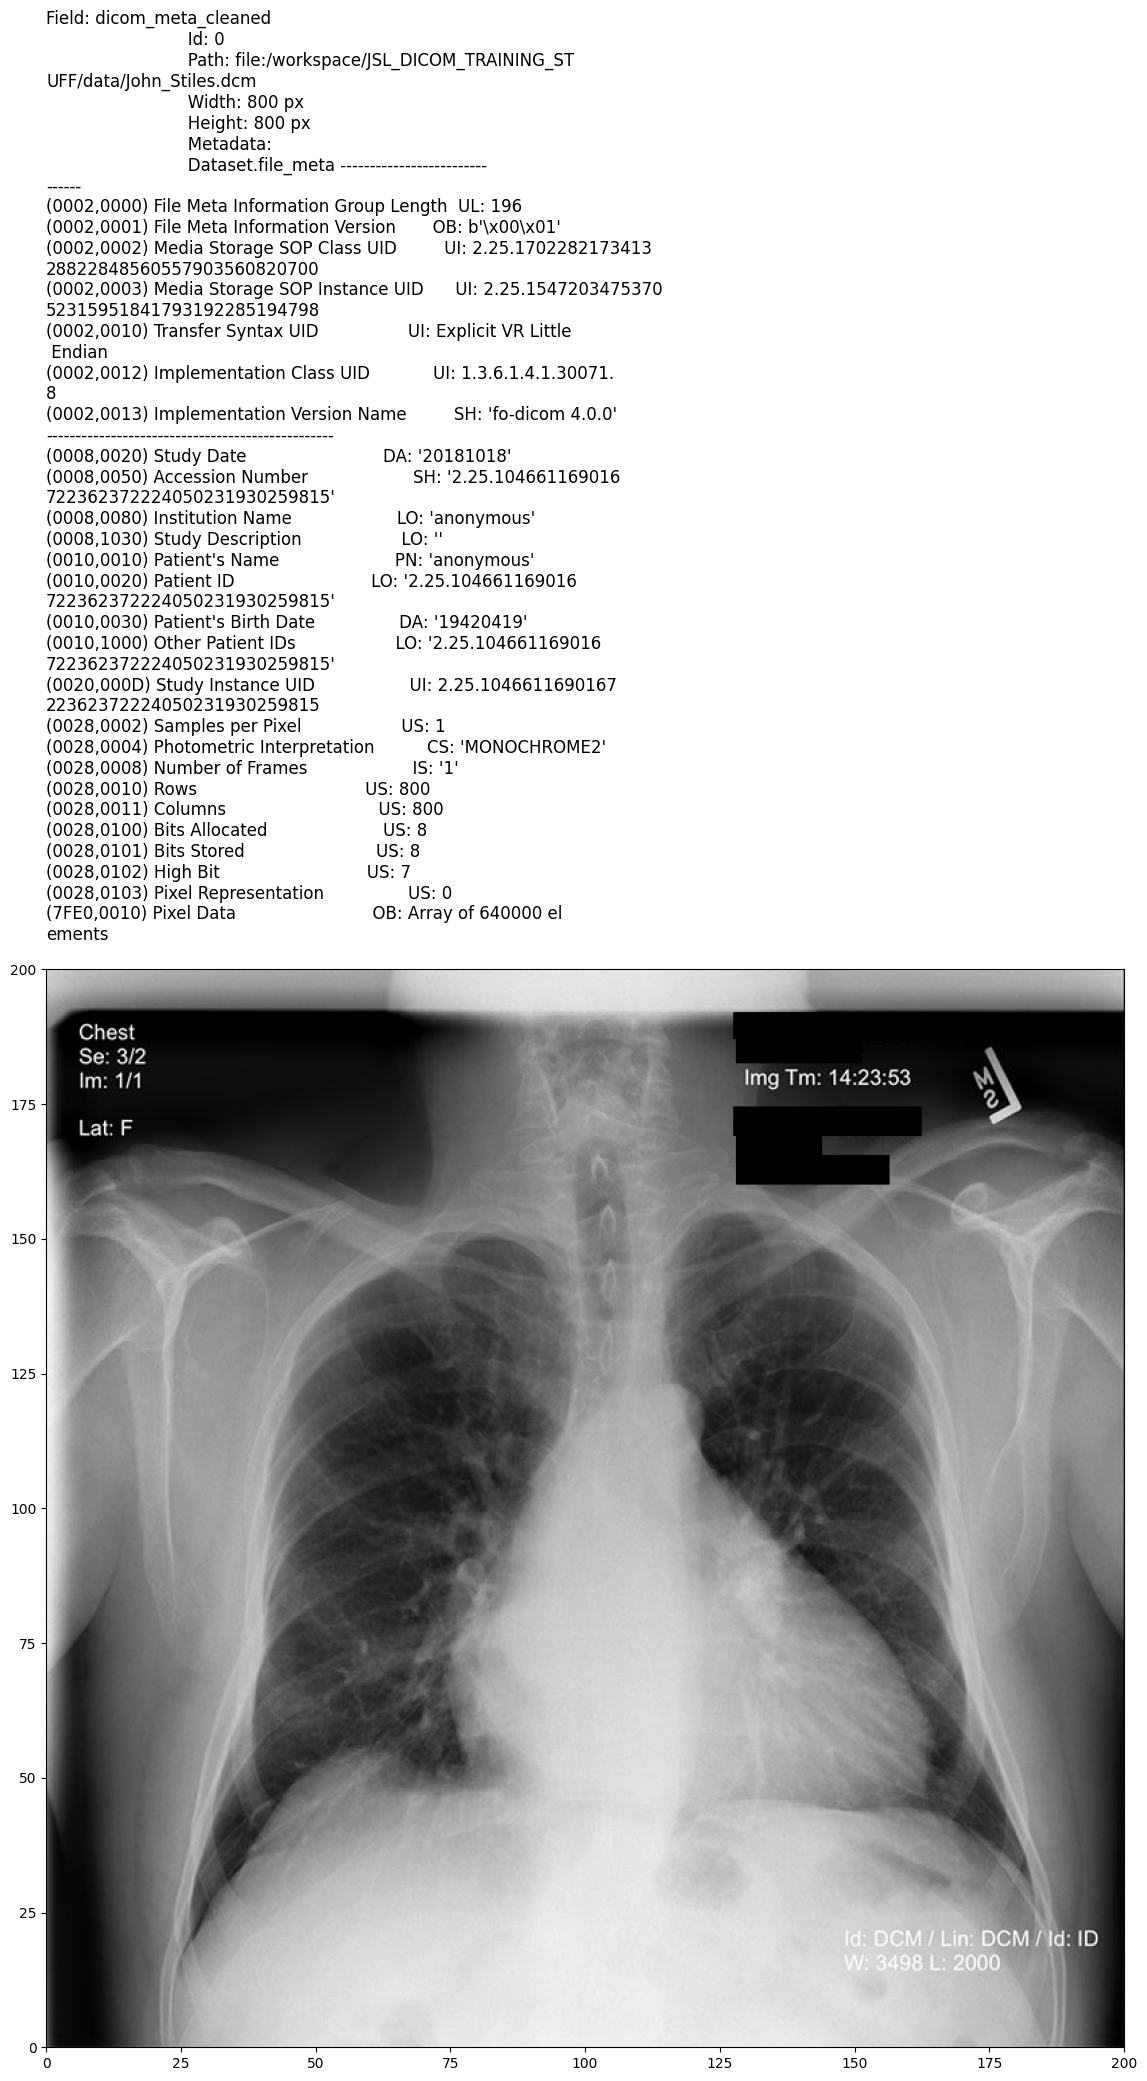

In [ ]:
display_dicom(result, "dicom_meta_cleaned")